In [1]:
from pandas import DataFrame, read_csv, get_dummies
from pathlib import Path
from numpy import array, random, argmax
import pickle
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers.core import Dropout
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder

In [2]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    #'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        #'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        #'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        #'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        #'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

Using TensorFlow backend.


In [3]:
db = Path("Z:/jupyternotebook/ASL-main/ASL-main/newdata/augmented_csv")
selected_db = db 
model_out = Path('Model')
model_name = model_out / 'ADB_9_95'
y = []
x = []
f = []
e = []

In [ ]:
for klass in list(selected_db.glob('*')):
    print(klass.name)
    for csv in klass.glob('*'):
        print(csv)
        d = read_csv(str(csv), header=None ).values
        if d.shape == (50,1629):
             e.append(d)
             y.append(klass.name)
        else:
             f.append(d)
        print(d.shape)

In [ ]:
with open('finalcsve.pkle','wb') as xyz:
    pickle.dump(e,xyz)

In [4]:
with open('finalcsvy.pkle','wb') as xyz:
    pickle.dump(y,xyz)

In [ ]:
with open('finalcsvf.pkle','wb') as xyz:
    pickle.dump(f,xyz)

In [5]:
# with open('finalcsve.pkle','rb') as xyz:
#    e = pickle.load(xyz)
with open("D:/ASL_DATASET/WIP final model/finalcsve.pkle",'rb') as xyz:
   e = pickle.load(xyz)
with open('finalcsvy.pkle','rb') as xyz:
   y = pickle.load(xyz)
with open('finalcsvf.pkle','rb') as xyz:
   f = pickle.load(xyz)
len(e)
len(f)
len(y)

16737

In [13]:
with open("D:/ASL_DATASET/WIP final model/finalcsve.pkle",'rb') as xyz:
   e = pickle.load(xyz)

In [ ]:
with open('Z:/jupyternotebook/ASL-main/ASL-main/finalcsvy.pkle','rb') as xyz:
   y = pickle.load(xyz)
print(y)

In [12]:
y = get_dummies(DataFrame(y)).values
print(y)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]


In [15]:
y = get_dummies(DataFrame(y)).values
e = array(e)

p = random.permutation(len(y))
y = y[p]
e = e[p]

print('Data Shape Check', e.shape, y.shape)

Data Shape Check (16737, 50, 1629) (16737, 8)


SPLITTING DATA

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(e, y, test_size=0.2, shuffle= True)

print(f"No. of training examples: {x_train.shape[0]}")
print(f"No. of testing examples: {x_valid.shape[0]}")

In [13]:
with open('finalcsvx_train.pkle','wb') as xyz:
    pickle.dump(x_train,xyz)
with open('finalcsvx_valid.pkle','wb') as xyz:
    pickle.dump(x_valid,xyz)
with open('finalcsvy_train.pkle','wb') as xyz:
    pickle.dump(y_train,xyz)
with open('finalcsvy_valid.pkle','wb') as xyz:
    pickle.dump(y_valid,xyz)

In [4]:
with open('finalcsvy_train.pkle','rb') as xyz:
    y_train = pickle.load(xyz)
with open('finalcsvx_train.pkle','rb') as xyz:
    x_train = pickle.load(xyz)
with open('finalcsvy_valid.pkle','rb') as xyz:
    y_valid = pickle.load(xyz)
with open('finalcsvx_valid.pkle','rb') as xyz:
    x_valid = pickle.load(xyz)

In [5]:
ACCURACY_THRESHOLD = 0.95
print('Model will stop training after reacing: ', ACCURACY_THRESHOLD)
class stop_(Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True
            
stop_training = stop_()

Model will stop training after reacing:  0.95


In [6]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=x_train.shape[1:]))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 64)            433664    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [7]:
a = Adam(learning_rate=0.00001)
H = model.compile(optimizer=a, loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
class_weight = {0: 1.,
                1: 1.,
                2: 1.,
                3: 1.,
               }

In [9]:
history = model.fit(x_train, y_train, epochs=1000, verbose=1, callbacks=[stop_training], class_weight=class_weight, validation_data=(x_valid,y_valid))

Epoch 1/1000
210/210 [==============================] - 34s 152ms/step - loss: 1.3323 - accuracy: 0.2753 - val_loss: 1.1301 - val_accuracy: 0.5545
Epoch 2/1000
210/210 [==============================] - 28s 136ms/step - loss: 1.1436 - accuracy: 0.4565 - val_loss: 1.0629 - val_accuracy: 0.5914
Epoch 3/1000
210/210 [==============================] - 32s 150ms/step - loss: 1.0634 - accuracy: 0.5689 - val_loss: 1.0168 - val_accuracy: 0.5497
Epoch 4/1000
210/210 [==============================] - 33s 156ms/step - loss: 0.9491 - accuracy: 0.5977 - val_loss: 0.6702 - val_accuracy: 0.6980
Epoch 5/1000
210/210 [==============================] - 29s 138ms/step - loss: 0.7883 - accuracy: 0.6716 - val_loss: 0.4815 - val_accuracy: 0.8374
Epoch 6/1000
210/210 [==============================] - 28s 131ms/step - loss: 0.6182 - accuracy: 0.7612 - val_loss: 0.4398 - val_accuracy: 0.8749
Epoch 7/1000
210/210 [==============================] - 28s 131ms/step - loss: 0.5321 - accuracy: 0.8084 - val_loss: 0

In [10]:
print('Saving model')
model.save(str(model_name))

Saving model
INFO:tensorflow:Assets written to: Model\ADB_9_95\assets


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


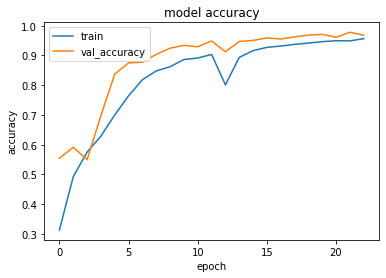

In [11]:
print(history.history.keys())
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val_accuracy'], loc='upper left')
plt.show()

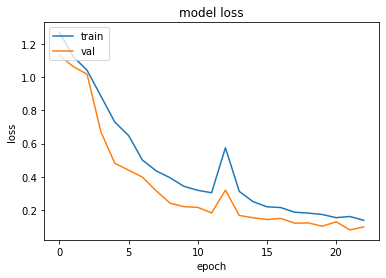

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [7]:
model_out = Path('Model')
model_name = model_out / 'ADB_9_95'
history = load_model(str(model_name))

In [63]:
# with open('finalcsvy_valid.pkle','rb') as xyz:
#     y_valid = pickle.load(xyz)

In [13]:
predictions = model.predict(x_valid)
predictions = argmax(predictions, axis=1)
y_true = argmax(y_valid, axis=1)

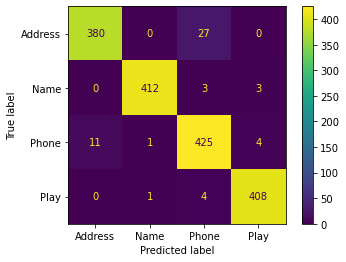

In [14]:
cm = confusion_matrix(y_true, predictions,labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Address','Name','Phone','Play'])
disp.plot()

In [75]:
with open('CM_A_R+V+M+R.pkle','wb') as xyz:
    pickle.dump(disp,xyz)

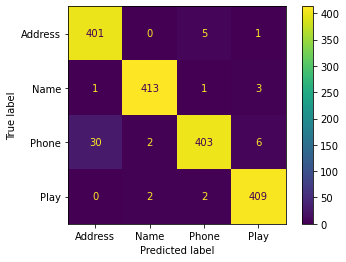

In [15]:
with open('CM_A_R+V+M+R.pkle','rb') as xyz:
    disp1 = pickle.load(xyz)
disp1.plot()

In [ ]:
# !pip install -U numpy==1.18.5 --user

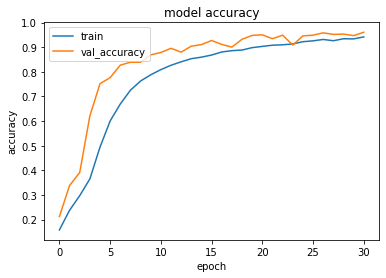

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

history = pd.read_csv("D:/ASL_DATASET/new structure/Models/30frame_8class/logs.csv")
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val_accuracy'], loc='upper left')
plt.show()

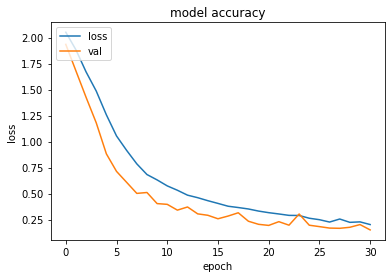

In [2]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()